In [1]:
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

import comptools as comp
import comptools.analysis.plotting as plotting
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to JupyROOT 6.09/02


In [2]:
df_sim_train, df_sim_test = comp.load_sim(config='IC86.2012')
feature_list, feature_labels = comp.analysis.get_training_features()

In [3]:
comp_class = True
target = 'MC_comp_class' if comp_class else 'MC_comp'
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

In [4]:
pipeline_str = 'BDT'
pipeline = comp.get_pipeline(pipeline_str)

In [5]:
df_sim_train.MC_comp.value_counts()

He4Nucleus     13047
PPlus          12758
O16Nucleus     12434
Fe56Nucleus    12016
Name: MC_comp, dtype: int64

In [6]:
energybins = comp.analysis.get_energybins()

## Visualizing feature space

In [11]:
cos_zenith_min = 0.85
cos_zenith_max = 0.9
cos_zenith_mask = np.logical_and(df_sim_train['lap_cos_zenith'] <= cos_zenith_max,
                                 df_sim_train['lap_cos_zenith'] >= cos_zenith_min)
cos_zenith_mask.sum()

3875

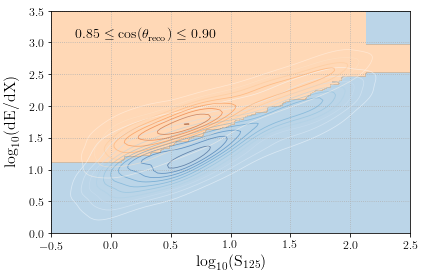

In [115]:
training_comps = ['PPlus', 'Fe56Nucleus']
comp_to_label_dict = {'PPlus': 0, 'Fe56Nucleus': 1}
cmaps = ['Blues', 'Oranges']

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

# Get restricted training DataFrame
comps_mask = df_sim_train['MC_comp'].isin(training_comps)
df_train = df_sim_train.loc[comps_mask].copy()
df_train['target'] = df_train['MC_comp'].apply(comp_to_label)

# Fit pipeline with training data for this fold
pipeline = comp.get_pipeline(pipeline_str)
# pipeline.named_steps['classifier'].set_params(loss='deviance')
pipeline.fit(df_train[feature_list], df_train['target'])


fig, ax = plt.subplots()
for MC_comp, cmap in zip(training_comps, cmaps):
    comp_mask = df_train['MC_comp'] == MC_comp
    sns.kdeplot(df_train.loc[cos_zenith_mask & comp_mask, 'log_s125'],
                df_train.loc[cos_zenith_mask & comp_mask, 'log_dEdX'],
                n_levels=10, cmap=cmap, label=MC_comp, alpha=0.5, ax=ax)

# Plot decision region using mlxtend
ax = plot_decision_regions(df_train.loc[cos_zenith_mask, feature_list].values,
                           df_train.loc[cos_zenith_mask, 'target'].values,
                           clf=pipeline, feature_index=[1, 2],
                           filler_feature_values={0: np.mean([cos_zenith_min, cos_zenith_max])},
                           res=0.02, legend=1, colors='C0,C1', hide_spines=False, 
                           ax=ax)    
    
ax.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
ax.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
zenith_range_str = '{:0.2f} '.format(cos_zenith_min) + \
                   '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + \
                   ' {:0.2f}'.format(cos_zenith_max)
ax.text(-0.3, 3.05, zenith_range_str, fontsize=14)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 3.5)
ax.grid()
ax.legend(loc='upper center')
decision_region_outfile = os.path.join(comp.paths.figures_dir, 'decision_regions', 'P-Fe-only.png')
comp.check_output_dir(decision_region_outfile)
plt.savefig(decision_region_outfile)
plt.show()

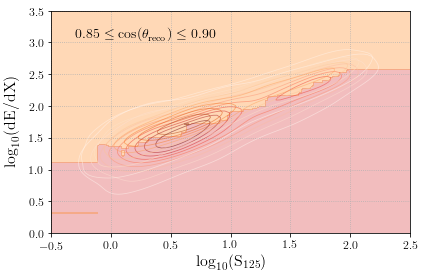

In [114]:
training_comps = ['O16Nucleus', 'Fe56Nucleus']
comp_to_label_dict = {'O16Nucleus': 0, 'Fe56Nucleus': 1}
cmaps = ['Reds', 'Oranges']

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

# Get restricted training DataFrame
comps_mask = df_sim_train['MC_comp'].isin(training_comps)
df_train = df_sim_train.loc[comps_mask].copy()
df_train['target'] = df_train['MC_comp'].apply(comp_to_label)

# Fit pipeline with training data for this fold
pipeline = comp.get_pipeline(pipeline_str)
# pipeline.named_steps['classifier'].set_params(loss='deviance')
pipeline.fit(df_train[feature_list], df_train['target'])


fig, ax = plt.subplots()
for MC_comp, cmap in zip(training_comps, cmaps):
    comp_mask = df_train['MC_comp'] == MC_comp
    sns.kdeplot(df_train.loc[cos_zenith_mask & comp_mask, 'log_s125'],
                df_train.loc[cos_zenith_mask & comp_mask, 'log_dEdX'],
                n_levels=10, cmap=cmap, label=MC_comp, alpha=0.5, ax=ax)

# Plot decision region using mlxtend
ax = plot_decision_regions(df_train.loc[cos_zenith_mask, feature_list].values,
                           df_train.loc[cos_zenith_mask, 'target'].values,
                           clf=pipeline, feature_index=[1, 2],
                           filler_feature_values={0: np.mean([cos_zenith_min, cos_zenith_max])},
                           res=0.02, legend=1, colors='C3,C1', hide_spines=False, 
                           ax=ax)    
    
ax.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
ax.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
zenith_range_str = '{:0.2f} '.format(cos_zenith_min) + \
                   '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + \
                   ' {:0.2f}'.format(cos_zenith_max)
ax.text(-0.3, 3.05, zenith_range_str, fontsize=14)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 3.5)
ax.grid()
ax.legend(loc='upper center')
decision_region_outfile = os.path.join(comp.paths.figures_dir, 'decision_regions', 'O-Fe-only.png')
comp.check_output_dir(decision_region_outfile)
plt.savefig(decision_region_outfile)
plt.show()

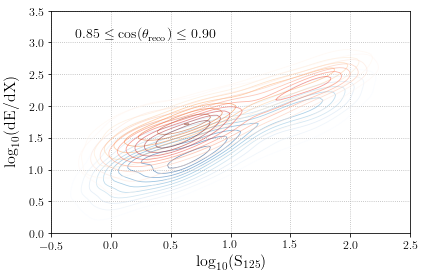

In [116]:
training_comps = ['PPlus', 'Fe56Nucleus', 'O16Nucleus']
comp_to_label_dict = {'PPlus': 0, 'Fe56Nucleus': 1, 'O16Nucleus':2}
cmaps = ['Blues', 'Oranges', 'Reds']

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

# Get restricted training DataFrame
comps_mask = df_sim_train['MC_comp'].isin(training_comps)
df_train = df_sim_train.loc[comps_mask].copy()
df_train['target'] = df_train['MC_comp'].apply(comp_to_label)

# Fit pipeline with training data for this fold
pipeline = comp.get_pipeline(pipeline_str)
pipeline.named_steps['classifier'].set_params(loss='deviance')
pipeline.fit(df_train[feature_list], df_train['target'])


fig, ax = plt.subplots()
for MC_comp, cmap in zip(training_comps, cmaps):
    comp_mask = df_train['MC_comp'] == MC_comp
    sns.kdeplot(df_train.loc[cos_zenith_mask & comp_mask, 'log_s125'],
                df_train.loc[cos_zenith_mask & comp_mask, 'log_dEdX'],
                n_levels=10, cmap=cmap, label=MC_comp, alpha=0.5, ax=ax)

# # Plot decision region using mlxtend
# ax = plot_decision_regions(df_train.loc[cos_zenith_mask, feature_list].values,
#                            df_train.loc[cos_zenith_mask, 'target'].values,
#                            clf=pipeline, feature_index=[1, 2],
#                            filler_feature_values={0: np.mean([cos_zenith_min, cos_zenith_max])},
#                            res=0.02, legend=1, colors='C0,C1,C3', hide_spines=False, 
#                            ax=ax)    
    
ax.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
ax.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
zenith_range_str = '{:0.2f} '.format(cos_zenith_min) + \
                   '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + \
                   ' {:0.2f}'.format(cos_zenith_max)
ax.text(-0.3, 3.05, zenith_range_str, fontsize=14)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 3.5)
ax.grid()
ax.legend(loc='upper center')
decision_region_outfile = os.path.join(comp.paths.figures_dir, 'decision_regions', 'P-O-Fe-only.png')
comp.check_output_dir(decision_region_outfile)
plt.savefig(decision_region_outfile)
plt.show()

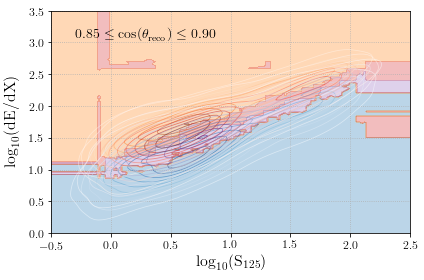

In [119]:
training_comps = ['PPlus', 'Fe56Nucleus', 'O16Nucleus', 'He4Nucleus']
comp_to_label_dict = {'PPlus': 0, 'Fe56Nucleus': 1, 'O16Nucleus':2, 'He4Nucleus': 3}
cmaps = ['Blues', 'Oranges', 'Reds', 'Purples']

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

# Get restricted training DataFrame
comps_mask = df_sim_train['MC_comp'].isin(training_comps)
df_train = df_sim_train.loc[comps_mask].copy()
df_train['target'] = df_train['MC_comp'].apply(comp_to_label)

# Fit pipeline with training data for this fold
pipeline = comp.get_pipeline(pipeline_str)
pipeline.named_steps['classifier'].set_params(loss='deviance')
pipeline.fit(df_train[feature_list], df_train['target'])


fig, ax = plt.subplots()
for MC_comp, cmap in zip(training_comps, cmaps):
    comp_mask = df_train['MC_comp'] == MC_comp
    sns.kdeplot(df_train.loc[cos_zenith_mask & comp_mask, 'log_s125'],
                df_train.loc[cos_zenith_mask & comp_mask, 'log_dEdX'],
                n_levels=10, cmap=cmap, label=MC_comp, alpha=0.5, ax=ax)

# Plot decision region using mlxtend
ax = plot_decision_regions(df_train.loc[cos_zenith_mask, feature_list].values,
                           df_train.loc[cos_zenith_mask, 'target'].values,
                           clf=pipeline, feature_index=[1, 2],
                           filler_feature_values={0: np.mean([cos_zenith_min, cos_zenith_max])},
                           res=0.02, legend=1, colors='C0,C1,C3,C4', hide_spines=False, 
                           ax=ax)    
    
ax.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
ax.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
zenith_range_str = '{:0.2f} '.format(cos_zenith_min) + \
                   '$\mathrm{ \leq \cos(\\theta_{reco}) \leq }$' + \
                   ' {:0.2f}'.format(cos_zenith_max)
ax.text(-0.3, 3.05, zenith_range_str, fontsize=14)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0, 3.5)
ax.grid()
ax.legend(loc='upper center')
decision_region_outfile = os.path.join(comp.paths.figures_dir, 'decision_regions', 'P-He-O-Fe.png')
comp.check_output_dir(decision_region_outfile)
plt.savefig(decision_region_outfile)
plt.show()

## P+He light & O+Fe heavy

In [83]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_accuracy = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
for train_index, test_index in skf.split(df_sim_train[feature_list], df_sim_train['target']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train.iloc[train_index]
    df_sim_test_fold = df_sim_train.iloc[test_index]
    # Fit pipeline with training data for this fold
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_label = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        pred_comp = np.array([comp.label_to_comp(i) for i in pred_label])
        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

        light_mask = pred_comp == 'light'

        counts_light = np.histogram(log_enegy[light_mask], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_light = counts_light/counts_total
        cv_accuracy[MC_comp].append(frac_light)

In [84]:
df_frac_light = pd.DataFrame.from_dict(cv_accuracy)
df_frac_light

,Fe56Nucleus,He4Nucleus,O16Nucleus,PPlus
0,"[0.144329896907, 0.132352941176, 0.16483516483...","[0.561797752809, 0.727272727273, 0.65217391304...","[0.464285714286, 0.3625, 0.291666666667, 0.419...","[0.744444444444, 0.70297029703, 0.80612244898,..."
1,"[0.121212121212, 0.168539325843, 0.07142857142...","[0.639534883721, 0.643564356436, 0.69767441860...","[0.26582278481, 0.402777777778, 0.347368421053...","[0.728395061728, 0.861386138614, 0.78, 0.81052..."
2,"[0.101449275362, 0.154761904762, 0.16304347826...","[0.608695652174, 0.683673469388, 0.69072164948...","[0.265957446809, 0.407894736842, 0.32323232323...","[0.818181818182, 0.821782178218, 0.86458333333..."
3,"[0.0947368421053, 0.166666666667, 0.1318681318...","[0.581395348837, 0.684210526316, 0.62135922330...","[0.345679012346, 0.375, 0.378378378378, 0.3333...","[0.78313253012, 0.807228915663, 0.770114942529..."
4,"[0.152777777778, 0.142857142857, 0.11111111111...","[0.686746987952, 0.646551724138, 0.71578947368...","[0.4, 0.30985915493, 0.358490566038, 0.4423076...","[0.702380952381, 0.8, 0.867924528302, 0.8, 0.8..."
5,"[0.0933333333333, 0.103448275862, 0.1265822784...","[0.592592592593, 0.672897196262, 0.67415730337...","[0.25, 0.358208955224, 0.417721518987, 0.39285...","[0.860465116279, 0.837837837838, 0.82882882882..."
6,"[0.131868131868, 0.126582278481, 0.10989010989...","[0.617647058824, 0.701030927835, 0.68269230769...","[0.261363636364, 0.366666666667, 0.36607142857...","[0.808219178082, 0.872881355932, 0.8125, 0.857..."
7,"[0.104166666667, 0.0989010989011, 0.0875, 0.11...","[0.637254901961, 0.715789473684, 0.68269230769...","[0.4, 0.451219512195, 0.281553398058, 0.302083...","[0.811594202899, 0.836956521739, 0.87735849056..."
8,"[0.106666666667, 0.164179104478, 0.10465116279...","[0.55, 0.636363636364, 0.670588235294, 0.70754...","[0.288888888889, 0.43956043956, 0.357723577236...","[0.845360824742, 0.811111111111, 0.84761904761..."
9,"[0.0958904109589, 0.151898734177, 0.2236842105...","[0.614583333333, 0.774193548387, 0.63218390804...","[0.340659340659, 0.404255319149, 0.30303030303...","[0.873417721519, 0.814516129032, 0.77083333333..."


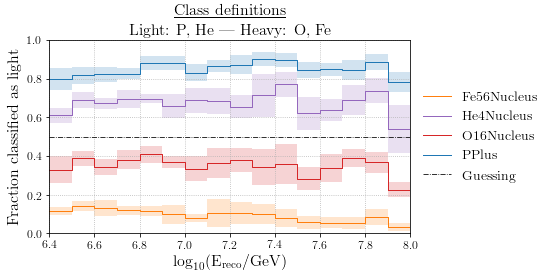

In [85]:
fig, ax = plt.subplots()
for MC_comp in df_frac_light.columns:
    frac_light_mean = df_frac_light[MC_comp].mean(axis=0)
    frac_light_std = df_frac_light[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_light_mean, yerr=frac_light_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction classified as light')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title(r'\underline{Class definitions}'+'\nLight: P, He | \t Heavy: O, Fe')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
outfile = os.path.join(comp.paths.figures_dir, 'fraction-classified-light_4-comp-training.png')
plt.savefig(outfile)
plt.show()

## P light & Fe heavy

In [86]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_accuracy = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
for train_index, test_index in skf.split(df_sim_train[feature_list], df_sim_train['target']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train.iloc[train_index]
    df_sim_test_fold = df_sim_train.iloc[test_index]
    # Restrict to only training on Fe56Nucleus and PPlus simulation
    iron_proton_mask = df_sim_train_fold['MC_comp'].isin(['Fe56Nucleus', 'PPlus']).values
    # Fit pipeline with training data for this fold
    pipeline.fit(df_sim_train_fold[feature_list][iron_proton_mask],
                 df_sim_train_fold['target'][iron_proton_mask])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_label = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        pred_comp = np.array([comp.label_to_comp(i) for i in pred_label])
        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

        light_mask = pred_comp == 'light'

        counts_light = np.histogram(log_enegy[light_mask], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_light = counts_light/counts_total
        cv_accuracy[MC_comp].append(frac_light)

In [87]:
df_frac_light = pd.DataFrame.from_dict(cv_accuracy)
df_frac_light

,Fe56Nucleus,He4Nucleus,O16Nucleus,PPlus
0,"[0.164948453608, 0.147058823529, 0.17582417582...","[0.595505617978, 0.753246753247, 0.66956521739...","[0.5, 0.375, 0.322916666667, 0.47619047619, 0....","[0.777777777778, 0.752475247525, 0.79591836734..."
1,"[0.151515151515, 0.191011235955, 0.07142857142...","[0.651162790698, 0.663366336634, 0.68604651162...","[0.354430379747, 0.472222222222, 0.36842105263...","[0.753086419753, 0.881188118812, 0.78, 0.84210..."
2,"[0.115942028986, 0.154761904762, 0.18478260869...","[0.619565217391, 0.724489795918, 0.70103092783...","[0.287234042553, 0.407894736842, 0.33333333333...","[0.818181818182, 0.851485148515, 0.875, 0.8105..."
3,"[0.0947368421053, 0.192307692308, 0.1098901098...","[0.639534883721, 0.705263157895, 0.61165048543...","[0.41975308642, 0.40625, 0.351351351351, 0.342...","[0.807228915663, 0.843373493976, 0.79310344827..."
4,"[0.194444444444, 0.15873015873, 0.148148148148...","[0.638554216867, 0.672413793103, 0.77894736842...","[0.3625, 0.352112676056, 0.349056603774, 0.490...","[0.72619047619, 0.831578947368, 0.867924528302..."
5,"[0.0933333333333, 0.114942528736, 0.1265822784...","[0.592592592593, 0.710280373832, 0.69662921348...","[0.285714285714, 0.402985074627, 0.45569620253...","[0.848837209302, 0.855855855856, 0.82882882882..."
6,"[0.175824175824, 0.139240506329, 0.10989010989...","[0.676470588235, 0.711340206186, 0.68269230769...","[0.329545454545, 0.4, 0.375, 0.465346534653, 0...","[0.835616438356, 0.872881355932, 0.8125, 0.857..."
7,"[0.09375, 0.120879120879, 0.15, 0.126436781609...","[0.647058823529, 0.726315789474, 0.67307692307...","[0.431578947368, 0.451219512195, 0.33980582524...","[0.840579710145, 0.858695652174, 0.86792452830..."
8,"[0.106666666667, 0.164179104478, 0.12790697674...","[0.59, 0.636363636364, 0.705882352941, 0.71698...","[0.344444444444, 0.494505494505, 0.39024390243...","[0.855670103093, 0.811111111111, 0.85714285714..."
9,"[0.0958904109589, 0.177215189873, 0.2236842105...","[0.614583333333, 0.806451612903, 0.63218390804...","[0.32967032967, 0.414893617021, 0.30303030303,...","[0.860759493671, 0.83064516129, 0.770833333333..."


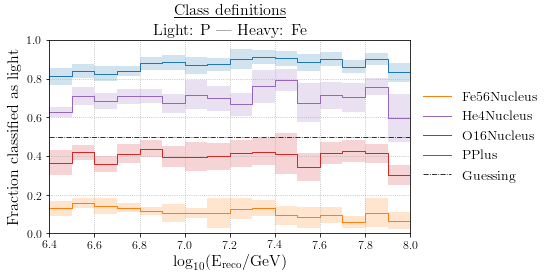

In [88]:
fig, ax = plt.subplots()
for MC_comp in df_frac_light.columns:
    frac_light_mean = df_frac_light[MC_comp].mean(axis=0)
    frac_light_std = df_frac_light[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_light_mean, yerr=frac_light_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction classified as light')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title(r'\underline{Class definitions}'+'\nLight: P | \t Heavy: Fe')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
outfile = os.path.join(comp.paths.figures_dir, 'fraction-classified-light_P-Fe-training-only.png')
plt.savefig(outfile)
plt.show()

In [13]:
comp_to_label_dict = {'PPlus': 0, 'Fe56Nucleus': 1}

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

In [14]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_correct = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
# Restrict to only training on PPlus and He4Nucleus simulation
proton_iron_mask = df_sim_train['MC_comp'].isin(['PPlus', 'Fe56Nucleus']).values
for train_index, test_index in skf.split(df_sim_train.loc[proton_iron_mask, feature_list],
                                         df_sim_train.loc[proton_iron_mask, 'target']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train[proton_iron_mask].iloc[train_index].copy()
    df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)
    
    df_sim_test_fold = df_sim_train[proton_iron_mask].iloc[test_index].copy()
    df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

    # Fit pipeline with training data for this fold
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        correctly_identified = pred_comp == df_sim_test_fold['target'][comp_mask]

        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values
        
        counts_correct = np.histogram(log_enegy[correctly_identified], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_correct = counts_correct/counts_total
        cv_correct[MC_comp].append(frac_correct)

In [15]:
df_frac_correct = pd.DataFrame.from_dict({key: value for key, value in cv_correct.items() if len(value) != 0})
df_frac_correct

,Fe56Nucleus,PPlus
0,"[0.8625, 0.895348837209, 0.852941176471, 0.845...","[0.785714285714, 0.845360824742, 0.80952380952..."
1,"[0.913580246914, 0.819444444444, 0.8375, 0.9, ...","[0.782051282051, 0.829787234043, 0.80198019802..."
2,"[0.880434782609, 0.837837837838, 0.875, 0.8222...","[0.831325301205, 0.875, 0.818181818182, 0.8988..."
3,"[0.8, 0.842857142857, 0.841463414634, 0.897959...","[0.857142857143, 0.872340425532, 0.86734693877..."
4,"[0.855421686747, 0.826666666667, 0.91111111111...","[0.792682926829, 0.789915966387, 0.85416666666..."
5,"[0.919540229885, 0.791666666667, 0.86046511627...","[0.794117647059, 0.847826086957, 0.83516483516..."
6,"[0.909090909091, 0.918918918919, 0.825, 0.8974...","[0.875, 0.823008849558, 0.794392523364, 0.9425..."
7,"[0.827160493827, 0.829545454545, 0.90697674418...","[0.825581395349, 0.790909090909, 0.79569892473..."
8,"[0.779220779221, 0.828282828283, 0.83157894736...","[0.865671641791, 0.901098901099, 0.85869565217..."
9,"[0.960526315789, 0.866666666667, 0.85897435897...","[0.770114942529, 0.818181818182, 0.87037037037..."


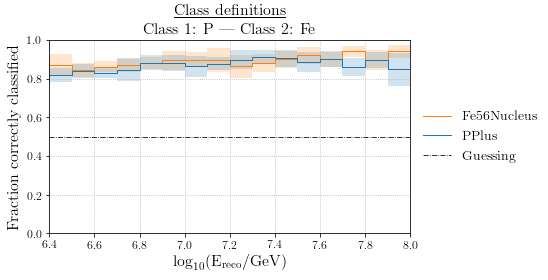

In [17]:
fig, ax = plt.subplots()
for MC_comp in df_frac_correct.columns:
    frac_light_mean = df_frac_correct[MC_comp].mean(axis=0)
    frac_light_std = df_frac_correct[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_light_mean, yerr=frac_light_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction correctly classified')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title(r'\underline{Class definitions}'+'\nClass 1: P | \t Class 2: Fe')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

outfile = os.path.join(comp.paths.figures_dir, 'fraction-correct_P-light-Fe-heavy-training.png')
plt.savefig(outfile)
plt.show()

## P light & He heavy

In [7]:
comp_to_label_dict = {'PPlus': 0, 'He4Nucleus': 1}

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_accuracy = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
# Restrict to only training on PPlus and He4Nucleus simulation
proton_helium_mask = df_sim_train['MC_comp'].isin(['PPlus', 'He4Nucleus']).values
for train_index, test_index in skf.split(df_sim_train.loc[proton_helium_mask, feature_list],
                                         df_sim_train.loc[proton_helium_mask, 'target']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train[proton_helium_mask].iloc[train_index].copy()
    df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)
    
    df_sim_test_fold = df_sim_train[proton_helium_mask].iloc[test_index].copy()
    df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

    # Fit pipeline with training data for this fold
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

        light_mask = pred_comp == 0

        counts_light = np.histogram(log_enegy[light_mask], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_light = counts_light/counts_total
        cv_accuracy[MC_comp].append(frac_light)

In [91]:
df_frac_light = pd.DataFrame.from_dict({key: value for key, value in cv_accuracy.items() if len(value) != 0})
df_frac_light

,He4Nucleus,PPlus
0,"[0.168539325843, 0.428571428571, 0.36521739130...","[0.444444444444, 0.50495049505, 0.5, 0.5208333..."
1,"[0.220930232558, 0.445544554455, 0.33720930232...","[0.456790123457, 0.673267326733, 0.55, 0.54736..."
2,"[0.29347826087, 0.428571428571, 0.309278350515...","[0.467532467532, 0.594059405941, 0.53125, 0.42..."
3,"[0.197674418605, 0.431578947368, 0.32038834951...","[0.469879518072, 0.578313253012, 0.52873563218..."
4,"[0.253012048193, 0.422413793103, 0.25263157894...","[0.464285714286, 0.547368421053, 0.51886792452..."
5,"[0.234567901235, 0.383177570093, 0.31460674157...","[0.546511627907, 0.576576576577, 0.54054054054..."
6,"[0.313725490196, 0.494845360825, 0.30769230769...","[0.452054794521, 0.64406779661, 0.583333333333..."
7,"[0.313725490196, 0.452631578947, 0.39423076923...","[0.521739130435, 0.652173913043, 0.55660377358..."
8,"[0.29, 0.409090909091, 0.376470588235, 0.33018...","[0.484536082474, 0.544444444444, 0.6, 0.541666..."
9,"[0.1875, 0.397849462366, 0.287356321839, 0.326...","[0.506329113924, 0.532258064516, 0.55208333333..."


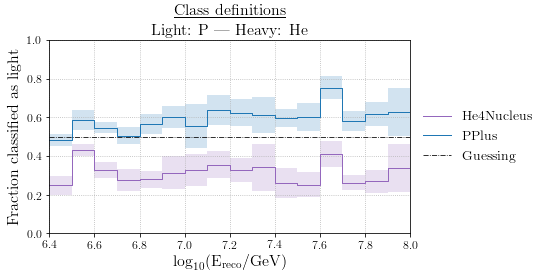

In [92]:
fig, ax = plt.subplots()
for MC_comp in df_frac_light.columns:
    frac_light_mean = df_frac_light[MC_comp].mean(axis=0)
    frac_light_std = df_frac_light[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_light_mean, yerr=frac_light_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction classified as light')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title(r'\underline{Class definitions}'+'\nLight: P | \t Heavy: He')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

outfile = os.path.join(comp.paths.figures_dir, 'fraction-classified-light_P-light-He-heavy-training.png')
plt.savefig(outfile)
plt.show()

In [10]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_correct = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
# Restrict to only training on PPlus and He4Nucleus simulation
proton_helium_mask = df_sim_train['MC_comp'].isin(['PPlus', 'He4Nucleus']).values
for train_index, test_index in skf.split(df_sim_train.loc[proton_helium_mask, feature_list],
                                         df_sim_train.loc[proton_helium_mask, 'target']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train[proton_helium_mask].iloc[train_index].copy()
    df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)
    
    df_sim_test_fold = df_sim_train[proton_helium_mask].iloc[test_index].copy()
    df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

    # Fit pipeline with training data for this fold
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        correctly_identified = pred_comp == df_sim_test_fold['target'][comp_mask]

        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values
        
        counts_correct = np.histogram(log_enegy[correctly_identified], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_correct = counts_correct/counts_total
        cv_correct[MC_comp].append(frac_correct)

In [11]:
df_frac_correct = pd.DataFrame.from_dict({key: value for key, value in cv_correct.items() if len(value) != 0})
df_frac_correct

,He4Nucleus,PPlus
0,"[0.831460674157, 0.571428571429, 0.63478260869...","[0.444444444444, 0.50495049505, 0.5, 0.5208333..."
1,"[0.779069767442, 0.554455445545, 0.66279069767...","[0.456790123457, 0.673267326733, 0.55, 0.54736..."
2,"[0.70652173913, 0.571428571429, 0.690721649485...","[0.467532467532, 0.594059405941, 0.53125, 0.42..."
3,"[0.802325581395, 0.568421052632, 0.67961165048...","[0.469879518072, 0.578313253012, 0.52873563218..."
4,"[0.746987951807, 0.577586206897, 0.74736842105...","[0.464285714286, 0.547368421053, 0.51886792452..."
5,"[0.765432098765, 0.616822429907, 0.68539325842...","[0.546511627907, 0.576576576577, 0.54054054054..."
6,"[0.686274509804, 0.505154639175, 0.69230769230...","[0.452054794521, 0.64406779661, 0.583333333333..."
7,"[0.686274509804, 0.547368421053, 0.60576923076...","[0.521739130435, 0.652173913043, 0.55660377358..."
8,"[0.71, 0.590909090909, 0.623529411765, 0.66981...","[0.484536082474, 0.544444444444, 0.6, 0.541666..."
9,"[0.8125, 0.602150537634, 0.712643678161, 0.673...","[0.506329113924, 0.532258064516, 0.55208333333..."


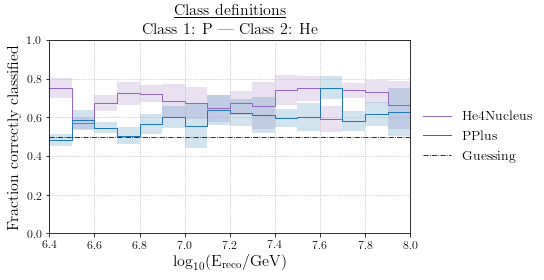

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [12]:
fig, ax = plt.subplots()
for MC_comp in df_frac_correct.columns:
    frac_light_mean = df_frac_correct[MC_comp].mean(axis=0)
    frac_light_std = df_frac_correct[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_light_mean, yerr=frac_light_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction correctly classified')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title(r'\underline{Class definitions}'+'\nClass 1: P | \t Class 2: He')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

outfile = os.path.join(comp.paths.figures_dir, 'fraction-correct_P-light-He-heavy-training.png')
plt.savefig(outfile)
plt.show()

## P light & He+O+Fe heavy

In [93]:
comp_to_label_dict = {'PPlus': 0, 'He4Nucleus': 1, 'O16Nucleus': 1, 'Fe56Nucleus': 1}

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))

In [94]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_accuracy = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
for train_index, test_index in skf.split(df_sim_train[feature_list], df_sim_train['target']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train.iloc[train_index].copy()
    df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)
    
    df_sim_test_fold = df_sim_train.iloc[test_index].copy()
    df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

    # Fit pipeline with training data for this fold
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

        light_mask = pred_comp == 0

        counts_light = np.histogram(log_enegy[light_mask], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_light = counts_light/counts_total
        cv_accuracy[MC_comp].append(frac_light)

In [95]:
df_frac_light = pd.DataFrame.from_dict(cv_accuracy)
df_frac_light

,Fe56Nucleus,He4Nucleus,O16Nucleus,PPlus
0,"[0.0103092783505, 0.0, 0.021978021978, 0.01098...","[0.0561797752809, 0.25974025974, 0.22608695652...","[0.0119047619048, 0.025, 0.03125, 0.0476190476...","[0.222222222222, 0.356435643564, 0.38775510204..."
1,"[0.030303030303, 0.0, 0.0119047619048, 0.0, 0....","[0.116279069767, 0.277227722772, 0.16279069767...","[0.0379746835443, 0.0555555555556, 0.031578947...","[0.345679012346, 0.415841584158, 0.38, 0.37894..."
2,"[0.0144927536232, 0.0119047619048, 0.0, 0.0, 0...","[0.0978260869565, 0.265306122449, 0.1443298969...","[0.0212765957447, 0.0263157894737, 0.010101010...","[0.337662337662, 0.415841584158, 0.38541666666..."
3,"[0.0105263157895, 0.0, 0.0, 0.0126582278481, 0...","[0.0697674418605, 0.221052631579, 0.1650485436...","[0.0123456790123, 0.078125, 0.027027027027, 0....","[0.265060240964, 0.385542168675, 0.40229885057..."
4,"[0.0, 0.015873015873, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.156626506024, 0.241379310345, 0.2, 0.122807...","[0.0375, 0.0422535211268, 0.0566037735849, 0.0...","[0.190476190476, 0.389473684211, 0.38679245283..."
5,"[0.0, 0.0114942528736, 0.0126582278481, 0.0, 0...","[0.0987654320988, 0.214953271028, 0.1910112359...","[0.0357142857143, 0.0298507462687, 0.088607594...","[0.348837209302, 0.414414414414, 0.36036036036..."
6,"[0.021978021978, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.176470588235, 0.20618556701, 0.153846153846...","[0.0568181818182, 0.1, 0.0, 0.039603960396, 0....","[0.287671232877, 0.398305084746, 0.35416666666..."
7,"[0.0, 0.0, 0.0, 0.0114942528736, 0.02325581395...","[0.196078431373, 0.263157894737, 0.22115384615...","[0.0315789473684, 0.0975609756098, 0.019417475...","[0.391304347826, 0.369565217391, 0.39622641509..."
8,"[0.0, 0.0, 0.0116279069767, 0.0, 0.0, 0.0, 0.0...","[0.11, 0.215909090909, 0.223529411765, 0.15094...","[0.0222222222222, 0.0989010989011, 0.056910569...","[0.288659793814, 0.355555555556, 0.40952380952..."
9,"[0.013698630137, 0.0253164556962, 0.0263157894...","[0.09375, 0.215053763441, 0.126436781609, 0.14...","[0.032967032967, 0.063829787234, 0.05050505050...","[0.316455696203, 0.33064516129, 0.395833333333..."


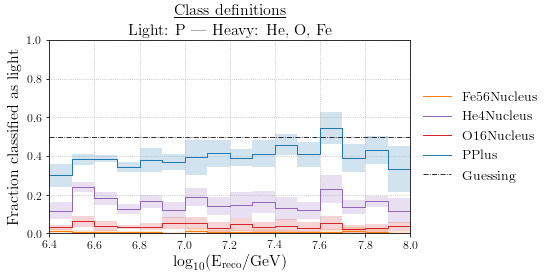

In [96]:
fig, ax = plt.subplots()
for MC_comp in df_frac_light.columns:
    frac_light_mean = df_frac_light[MC_comp].mean(axis=0)
    frac_light_std = df_frac_light[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_light_mean, yerr=frac_light_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction classified as light')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title(r'\underline{Class definitions}'+'\nLight: P | \t Heavy: He, O, Fe')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

outfile = os.path.join(comp.paths.figures_dir, 'fraction-classified-light_P-light-else-heavy-training.png')
plt.savefig(outfile)
plt.show()

## Pairwise classification

In [47]:
from itertools import combinations

In [48]:
MC_comp_list = ['PPlus', 'He4Nucleus', 'O16Nucleus', 'Fe56Nucleus']
get_MC_comp_name = {'PPlus':'P', 'He4Nucleus':'He', 'O16Nucleus':'O', 'Fe56Nucleus':'Fe'}

In [49]:
a = list(combinations(MC_comp_list, 2))

In [50]:
comp1, comp2 = a[0]

In [51]:
comp1

'PPlus'

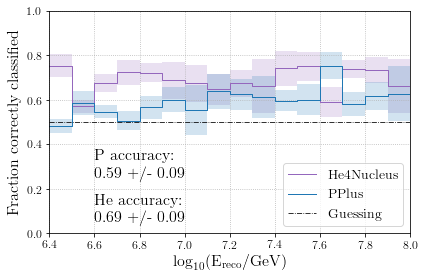

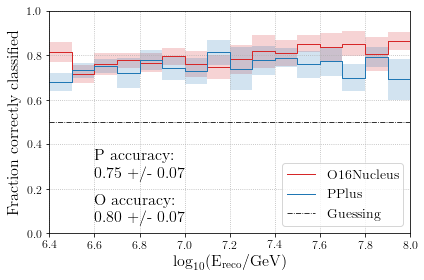

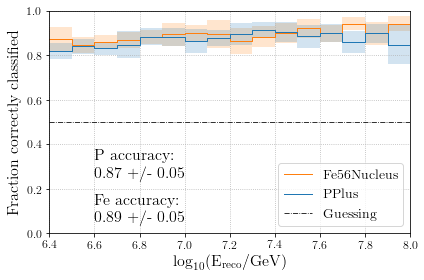

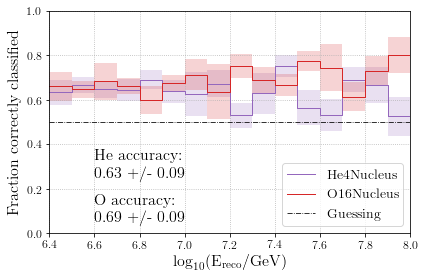

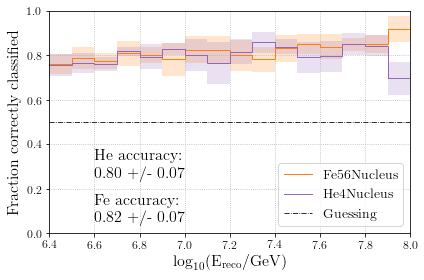

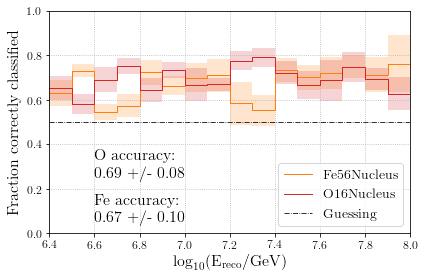

In [90]:
for comp1, comp2 in list(combinations(MC_comp_list, 2)):
    
    comp1_name = get_MC_comp_name[comp1]
    comp2_name = get_MC_comp_name[comp2]
    print(comp1_name, comp2_name)

    comp_to_label_dict = {comp1: 0, comp2: 1}

    def comp_to_label(composition):
        try:
            return comp_to_label_dict[composition]
        except KeyError:
            raise KeyError('Incorrect composition ({}) entered'.format(composition))


    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
    cv_correct = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
    # Restrict to only training on PPlus and He4Nucleus simulation
    comps_mask = df_sim_train['MC_comp'].isin([comp1, comp2]).values
    for train_index, test_index in skf.split(df_sim_train.loc[comps_mask, feature_list],
                                             df_sim_train.loc[comps_mask, 'target']):
        # Get training/testing data for this fold
        df_sim_train_fold = df_sim_train[comps_mask].iloc[train_index].copy()
        df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)

        df_sim_test_fold = df_sim_train[comps_mask].iloc[test_index].copy()
        df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

        # Fit pipeline with training data for this fold
        pipeline = comp.get_pipeline(pipeline_str)
        pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
        # Get fraction of events classified as light for each MC composition
        for MC_comp in df_sim_train_fold.MC_comp.unique():
            comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
            pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
            correctly_identified = pred_comp == df_sim_test_fold['target'][comp_mask]

            log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

            counts_correct = np.histogram(log_enegy[correctly_identified], bins=energybins.log_energy_bins)[0]
            counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
            frac_correct = counts_correct/counts_total
            cv_correct[MC_comp].append(frac_correct)

    df_frac_correct = pd.DataFrame.from_dict({key: value for key, value in cv_correct.items() if len(value) != 0})


    fig, ax = plt.subplots()
    for MC_comp in df_frac_correct.columns:
        frac_mean = df_frac_correct[MC_comp].mean(axis=0)
        frac_std = df_frac_correct[MC_comp].values.std(axis=0)
        plotting.plot_steps(energybins.log_energy_bins, frac_mean, yerr=frac_std, 
                            color=color_dict[MC_comp], label=MC_comp, ax=ax)
    
    for composition, name, y_coord in zip([comp1, comp2], [comp1_name, comp2_name], [0.25, 0.05]):
        acc_mean = np.concatenate(df_frac_correct[composition]).mean()
        acc_std = np.concatenate(df_frac_correct[composition]).std()
        ax.text(6.6, y_coord, '{} accuracy:\n {:0.2f} +/- {:0.2f}'.format(name, acc_mean, acc_std), 
                fontsize=16)

    ax.axhline(0.5, marker='None', ls='-.', c='k', label='Guessing')
    ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
    ax.set_ylim(0, 1)
    ax.set_ylabel('Fraction correctly classified')
    ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
#     ax.set_title(r'\underline{Class definitions}'+'\nClass 1: {} | \t Class 2: {}'.format(comp1_name, comp2_name))
    ax.grid()
    # leg = plt.legend(loc='upper center', frameon=False,
    #           bbox_to_anchor=(0.5,  # horizontal
    #                           1.25),# vertical 
    #           ncol=3, fancybox=False)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.legend(loc='lower right')

    outfile = os.path.join(comp.paths.figures_dir,
                           'fraction-correct_{}-light-{}-heavy-training.png'.format(comp1_name, comp2_name))
    plt.savefig(outfile)
    plt.show()

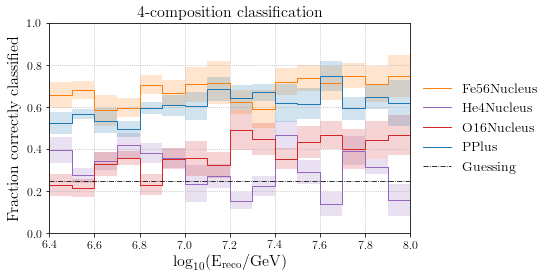

In [84]:
comp_to_label_dict = {'PPlus': 0, 'He4Nucleus': 1, 'O16Nucleus': 2, 'Fe56Nucleus': 3}

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_correct = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
# Restrict to only training on PPlus and He4Nucleus simulation
for train_index, test_index in skf.split(df_sim_train[feature_list], df_sim_train['MC_comp']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train.iloc[train_index].copy()
    df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)

    df_sim_test_fold = df_sim_train.iloc[test_index].copy()
    df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

    # Fit pipeline with training data for this fold
    pipeline = comp.get_pipeline(pipeline_str)
    pipeline.named_steps['classifier'].set_params(loss='deviance')
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        correctly_identified = pred_comp == df_sim_test_fold['target'][comp_mask]

        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

        counts_correct = np.histogram(log_enegy[correctly_identified], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_correct = counts_correct/counts_total
        cv_correct[MC_comp].append(frac_correct)

df_frac_correct = pd.DataFrame.from_dict({key: value for key, value in cv_correct.items() if len(value) != 0})

fig, ax = plt.subplots()
for MC_comp in df_frac_correct.columns:
    frac_mean = df_frac_correct[MC_comp].mean(axis=0)
    frac_std = df_frac_correct[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_mean, yerr=frac_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)

np.concatenate(df_frac_correct.Fe56Nucleus).mean()
np.concatenate(df_frac_correct.Fe56Nucleus).std()

ax.axhline(0.25, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction correctly classified')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title('4-composition classification')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

outfile = os.path.join(comp.paths.figures_dir, 'fraction-correct_4-component-training.png')
plt.savefig(outfile)
plt.show()

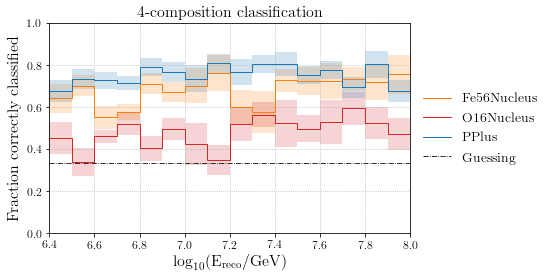

In [10]:
comp_to_label_dict = {'PPlus': 0, 'O16Nucleus': 1, 'Fe56Nucleus': 2}

def comp_to_label(composition):
    try:
        return comp_to_label_dict[composition]
    except KeyError:
        raise KeyError('Incorrect composition ({}) entered'.format(composition))


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
cv_correct = {MC_comp: [] for MC_comp in df_sim_train.MC_comp.unique()}
# Restrict to only training on PPlus and He4Nucleus simulation
comps_mask = df_sim_train['MC_comp'].isin(['PPlus', 'O16Nucleus', 'Fe56Nucleus']).values
for train_index, test_index in skf.split(df_sim_train.loc[comps_mask, feature_list],
                                         df_sim_train.loc[comps_mask, 'MC_comp']):
    # Get training/testing data for this fold
    df_sim_train_fold = df_sim_train[comps_mask].iloc[train_index].copy()
    df_sim_train_fold['target'] = df_sim_train_fold['MC_comp'].apply(comp_to_label)

    df_sim_test_fold = df_sim_train[comps_mask].iloc[test_index].copy()
    df_sim_test_fold['target'] = df_sim_test_fold['MC_comp'].apply(comp_to_label)

    # Fit pipeline with training data for this fold
    pipeline = comp.get_pipeline(pipeline_str)
    pipeline.named_steps['classifier'].set_params(loss='deviance')
    pipeline.fit(df_sim_train_fold[feature_list], df_sim_train_fold['target'])
    # Get fraction of events classified as light for each MC composition
    for MC_comp in df_sim_train_fold.MC_comp.unique():
        comp_mask = df_sim_test_fold['MC_comp'] == MC_comp
        pred_comp = pipeline.predict(df_sim_test_fold[feature_list][comp_mask])
        correctly_identified = pred_comp == df_sim_test_fold['target'][comp_mask]

        log_enegy = df_sim_test_fold['lap_log_energy'][comp_mask].values

        counts_correct = np.histogram(log_enegy[correctly_identified], bins=energybins.log_energy_bins)[0]
        counts_total = np.histogram(log_enegy, bins=energybins.log_energy_bins)[0]
        frac_correct = counts_correct/counts_total
        cv_correct[MC_comp].append(frac_correct)

df_frac_correct = pd.DataFrame.from_dict({key: value for key, value in cv_correct.items() if len(value) != 0})

fig, ax = plt.subplots()
for MC_comp in df_frac_correct.columns:
    frac_mean = df_frac_correct[MC_comp].mean(axis=0)
    frac_std = df_frac_correct[MC_comp].values.std(axis=0)
    plotting.plot_steps(energybins.log_energy_bins, frac_mean, yerr=frac_std, 
                        color=color_dict[MC_comp], label=MC_comp, ax=ax)

np.concatenate(df_frac_correct.Fe56Nucleus).mean()
np.concatenate(df_frac_correct.Fe56Nucleus).std()

ax.axhline(1/3, marker='None', ls='-.', c='k', label='Guessing')
ax.set_xlim(energybins.log_energy_min, energybins.log_energy_max)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction correctly classified')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_title('4-composition classification')
ax.grid()
# leg = plt.legend(loc='upper center', frameon=False,
#           bbox_to_anchor=(0.5,  # horizontal
#                           1.25),# vertical 
#           ncol=3, fancybox=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

outfile = os.path.join(comp.paths.figures_dir, 'fraction-correct_3-component-training.png')
plt.savefig(outfile)
plt.show()